---
title: Sketch and Precondition
description: High-accuracy linear regression using randomized sketching for preconditioning with detailed coverage of preconditioned iterative methods
keywords: [sketch and precondition, preconditioning, LSQR, condition number, sketched QR, convergence acceleration, randomized preconditioning]
numbering:
  equation:
    enumerator: 4.%s
    continue: true
  proof:theorem:
    enumerator: 4.%s
    continue: true
  proof:algorithm:
    enumerator: 4.%s
    continue: true
  proof:definition:
    enumerator: 4.%s
    continue: true
  proof:proposition:
    enumerator: 4.%s
    continue: true
---

The sketch-and-precondition approach provides a powerful alternative to both direct factorization methods and the [sketch-and-solve](sketch-and-solve.ipynb) paradigm for solving {eq}`task-regression`.
Unlike sketch-and-solve, which may sacrifice accuracy for speed, sketch-and-precondition maintains high accuracy while achieving significant computational speedups.

The key insight behind sketch-and-precondition is to use a randomized sketch to construct a preconditioner that improves the conditioning the {eq}`task-regression`.

## Preconditioned Iterative Methods

Given any invertivle matrix $\vec{M}\in\R^{d\times d}$ (called a *preconditioner*), solving {eq}`task-regression` is equivalent to solving
```{math}
:label: eqn-preconditioned-regression
\min_{\vec{y}} \|\vec{A}\vec{M}\vec{y} - \vec{b}\|
,\quad
\vec{x} = \vec{M}\vec{y}.
```
The convergence of iterative methods applied to the preconditioned system depends on the condition number of the preconditioned matrix $\vec{A}\vec{M}$.

:::{prf:theorem}

Suppose LSQR is applied to {ref}`eqn-preconditioned-regression` for $t$ iterations from initial guess $\vec{x}_0$ to produce an approximate solution $\vec{x}_t$.
Then, for some 
\begin{equation*}
t = O \left( \cond(\vec{A}\vec{M}) \log \left( \frac{1}{\varepsilon} \right) \right),
\end{equation*}
it holds that
\begin{equation*}
\| \vec{A}(\vec{x}^* - \vec{x}_t) \| \leq \varepsilon \|\vec{A}(\vec{x}^* - \vec{x}_0)\|.
\end{equation*}
This requires $t$ matrix-vector products with $\vec{A}$, $\vec{A}^\T$, $\vec{M}$ and $\vec{M}^\T$, in addition to $O(tn)$ flops.
:::



## Randomized Preconditioning

The basic sketch-and-precondition algorithm follows a two-stage approach: first construct a preconditioner using a randomized sketch, then solve the preconditioned system using an iterative method.

:::{prf:algorithm} Sketch and Precondition
:label: sketch-and-precondition

**Input:** $\vec{A}\in\R^{n\times d}$, $\vec{b}\in\R^n$, sketching dimension $k$, tolerance $\varepsilon$

1. Get $\vec{Q}_1,\vec{R}_1 = \Call{Sketched-QR}(\vec{A},k)$
1. Form preconditioner $\vec{M} = \vec{R}^{-1}$
1. Get initial guess $\vec{x}_0$ from sketch-and-solve
1. Set $\widehat{\vec{x}} = \Call{Iterative-Method}(\vec{A},\vec{b},\vec{x}_0,\vec{M})$

**Output:** $\vec{x}$
:::

The role of the sketch-and-solve initial guess is to ensure that the initial error is bounded. 


In [1]:
def sketch_and_precondition(A,b,k,zeta,n_iters,rng):
    
    n, d = A.shape
    S = sparse_stack_sketch(n,k,zeta,rng) 
    Y = S @ A 
    Q,R = np.linalg.qr(Y, mode='reduced')

    x0 = sp.linalg.solve_triangular(R,Q.T@(S@b),lower=False)

    M = sp.linalg.solve_triangular(R,np.eye(d),lower=False)

    x = lsqr(A,b,x0,M,n_iters)

    return x


Any version of [Sketched-QR algorithm](../03-QR-Factorization/randomized-cholesky-qr.ipynb) that produces subspace embedding can be used.

:::{prf:theorem}

Suppose $\vec{A}$ is full-rank and the sketch $\vec{S}$ used by the [Sketched-QR algorithm](../03-QR-Factorization/randomized-cholesky-qr.ipynb) is an $\varepsilon$-subspace embedding for $\vec{A}$.
Then 
\begin{equation*}
\cond(\vec{A}\vec{M}) \leq  \frac{1+\varepsilon}{1-\varepsilon}.
\end{equation*}
:::

:::{prf:proof}
:class: dropdown
:enumerated: false

Recall $\vec{A} = \vec{Q}\vec{R}$.
By {eq}`sketched-qr-well-conditioned`,
\begin{equation*}
\cond(\vec{A}\vec{M}) = \cond(\vec{A}\vec{R}^{-1}) = \cond(\vec{Q}) \leq (1+\varepsilon)/(1-\varepsilon)
\end{equation*}
:::

## Numerical Experiment

We now perform  numerical experiment to illustrate the behavior of sketch-and-precondition. 
Here we solve an ill-conditioned regression problem and compare the convergence of sketch-and-precondition for several choices of embedding dimension. 
Using a large embedding dimension leads to a better preconditioner and faster convergence, but requires some additional time to compute the preconditioner.


In [2]:
import numpy as np
import scipy as sp
import time
import pandas as pd

import matplotlib.pyplot as plt


import sys
sys.path.append('../')
from randnla import *

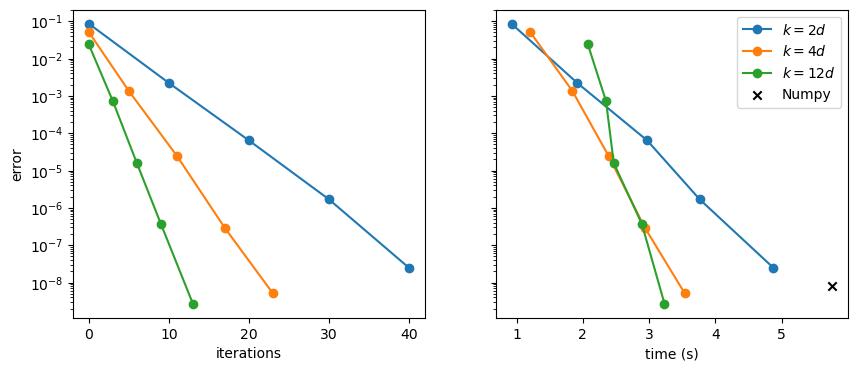

In [3]:
# ========================
# Set up the test problem
# ========================
n = 100_000
d = 800
cond = 1e8


U, s, Vt = np.linalg.svd(np.random.rand(n, d), full_matrices=False)
s = np.geomspace(1/cond, 1, d)  # Controlled singular values for numerical stability
A = U @ np.diag(s) @ Vt

b_norm = 1
residual_norm = .1

v = np.random.randn(n)
v_span = U @ (U.T @ v)
v_perp = v - v_span
v_span /= np.linalg.norm(v_span)
v_perp /= np.linalg.norm(v_perp)

b = v_span * np.sqrt(b_norm**2 - residual_norm**2) + v_perp * residual_norm

x_true = Vt.T@(np.diag(1/s)@(U.T@b))

# ========================
# Now run the experiment
# ========================

zeta = 4
rng = np.random.default_rng(0) 

experiments = [
    {'k': 2*d,'iters': np.linspace(0,40,5,dtype='int')},
    {'k': 4*d,'iters': np.linspace(0,23,5,dtype='int')},
    {'k': 12*d,'iters': np.linspace(0,13,5,dtype='int')},
]

n_repeat = 5
errs = {}
times = {}

for experiment in experiments:
    k = experiment['k']
    iters = experiment['iters']

    for n_iters in iters:

        start = time.time()
        for _ in range(n_repeat):
            x = sketch_and_precondition(A,b,k,zeta,n_iters,rng)
        end = time.time()
        avg_time = (end - start) / n_repeat
        
        errs[k,n_iters] = np.linalg.norm(x-x_true)/np.linalg.norm(x_true)
        times[k,n_iters] = avg_time

start = time.time()
for _ in range(n_repeat):
    x_np = np.linalg.lstsq(A,b,rcond=None)[0]
end = time.time()

avg_time_np = (end - start) / n_repeat
err_np = np.linalg.norm(A@(x_np-x_true))/np.linalg.norm(A@x_true)


# ========================
# Plot the results
# ========================

fig, axs = plt.subplots(1,2,figsize=(10, 4),sharey=True)

for experiment in experiments:
    k = experiment['k']
    iters = experiment['iters']
    
    times_k = [times[k,n_iters] for n_iters in iters]
    errs_k = [errs[k,n_iters] for n_iters in iters]

    axs[0].plot(iters,errs_k,marker='o',label=f'$k={k//d}d$')
    axs[1].plot(times_k,errs_k,marker='o',label=f'$k={k//d}d$')

axs[1].scatter(avg_time_np,err_np,marker='x',color='k',label='Numpy')

axs[0].set_xlabel('iterations')
axs[1].set_xlabel('time (s)')

axs[0].set_ylabel('error')
plt.legend()
plt.yscale('log')

Even when targeting full-accuracy, sketch and precondition outperforms Numpy.
In settings where moderate accuracy is sufficient or where $\vec{A}$ is sparse, the speedups may be even more substantial!

Note also that as the embedding dimension $k$ increases, the quality of the preconditioner improves, leading to faster convergence of the iterative method.
However, this also increases the time required to compute the preconditioner.
A good implementation will balance these trade-offs to achieve the best overall performance.